### Loss Testing

In [25]:
import torch
from FISHClass.utils.evaluation import get_top_model
from FISHClass.datasets import MYCN
from torch.utils.data import DataLoader
from FISHClass.utils.device import best_gpu
import matplotlib.pyplot as plt
from FISHClass.utils.visualize import bbox_on_image
import numpy as np
from tqdm import tqdm

In [26]:
model = torch.load(get_top_model("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/TRAIN_RESULTS/FASTER-R-CNN/EXP_1"))["model"]

In [27]:
dataset = MYCN("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/TRAINING_DATA_5K.h5", "train")
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [28]:
device = best_gpu()
model.eval()
model.to(device)
areas = []
for X, y in tqdm(dataloader):
    
    ret = model(X.to(device))
    
    for r, x, t in zip(ret,X, y):
        labels = r["labels"]
        boxes = r["boxes"][labels != 1]
        scores = r["scores"][labels != 1]
        labels = labels[labels != 1]
        r["image"] = x
        
        A, B = torch.where(x[2]!=0)
        sz = (A.max()-A.min())*(B.max()-B.min())
        area = torch.clip(torch.sum((boxes[:,2]-boxes[:,0]) * (boxes[:,3]-boxes[:,1])*scores)/sz,0,1).item()
        areas.append((area,t))
    #for v,s in zip(((boxes[:,2]-boxes[:,0]) * (boxes[:,3]-boxes[:,1])), scores):
        #print(v.item(),s.item())
    #plt.imshow(bbox_on_image(ret, ret=True))
    #plt.show()
    if len(areas) > 1000:
        break
    

 12%|█▏        | 62/500 [00:43<05:07,  1.42it/s]


In [29]:
areas = np.array(areas)

In [30]:
a = areas[:, 0]
y = areas[:, 1]

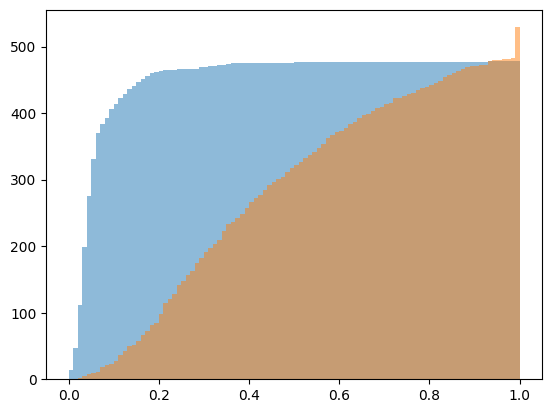

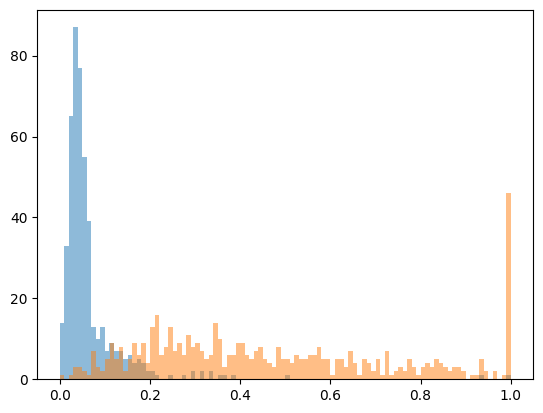

In [31]:
plt.hist(a[y==0], bins=100, alpha=.5, cumulative=True)
plt.hist(a[y==1], bins=100, alpha=.5, cumulative=True)
plt.show()

plt.hist(a[y==0], bins=100, alpha=.5)
plt.hist(a[y==1], bins=100, alpha=.5)
plt.show()

In [ ]:
import numpy as np
x = torch.tensor(np.linspace(0,1, 1000))
y = -torch.log(x)
y2 = 0.5*-torch.log(1-torch.abs(x-1))

plt.plot(x,y)
plt.plot(x,y2)

In [3]:
model = torch.load(get_top_model("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/TRAIN_RESULTS/FEATURESPACE/EXP_1"))["model"]

In [15]:
from matplotlib.pyplot import cla


def get_cell_bbox(patch):
    
    A, B = torch.where(patch[2]!=0)
    sz = (A.max()-A.min())*(B.max()-B.min())
    return sz

def get_bbox_size(patch_fs):
    
    x0, y0, x1, y1 = patch_fs[:,0], patch_fs[:,1], patch_fs[:,2], patch_fs[:,3]
    c = patch_fs[:,4]
    s = patch_fs[:,5]
    
    area = torch.sum((x1-x0) * (y1-y0)*s)

    return area

In [24]:
dataset = MYCN("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/TRAINING_DATA_5K.h5", "train", double_return=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

device = best_gpu()
model.eval()
model.redefine_device(device)
areas = []
for X, X2, y in tqdm(dataloader):
    
    y_hat, fs = model(X.to(device), X2.to(device), return_box_fs=True)
    fs = fs.reshape(-1, 100, 6)

    sizes = torch.tensor([get_cell_bbox(patch) for patch in X2])
    areas = torch.tensor([get_bbox_size(patch_fs) for patch_fs in fs])
    
    portion = torch.clip((areas/sizes), 0, 1)

    


  0%|          | 1/500 [00:00<05:25,  1.53it/s]

tensor([0.0999, 0.7408, 0.1327, 0.6472, 1.0000, 0.6058, 1.0000, 0.1407, 0.1295,
        0.0660, 0.2715, 0.8426, 0.1018, 0.1525, 0.1077, 0.0572])


  0%|          | 2/500 [00:01<05:18,  1.56it/s]

tensor([0.0795, 0.1338, 0.0877, 0.0913, 0.3307, 0.0369, 0.1944, 0.7890, 0.0134,
        0.1535, 0.4670, 0.1285, 0.4067, 0.0674, 0.0813, 0.1316])


  1%|          | 3/500 [00:01<05:15,  1.58it/s]

tensor([0.0564, 0.2764, 0.3469, 1.0000, 0.0902, 0.1175, 0.1187, 0.1148, 0.7378,
        0.1361, 0.1610, 0.6073, 0.1165, 0.2628, 0.0476, 0.5773])


  1%|          | 4/500 [00:02<05:10,  1.60it/s]

tensor([0.7690, 0.2218, 0.1280, 0.0892, 0.0318, 0.2241, 0.0865, 0.1122, 0.0799,
        0.0958, 0.0581, 0.2987, 0.3100, 0.0812, 0.3880, 0.0561])


  1%|          | 5/500 [00:03<05:07,  1.61it/s]

tensor([0.6079, 0.1256, 0.0303, 0.2474, 0.0943, 0.3409, 1.0000, 0.7957, 0.4551,
        0.0713, 0.9321, 0.0387, 0.6134, 0.1579, 0.2748, 0.0966])


  1%|          | 6/500 [00:03<05:04,  1.62it/s]

tensor([0.5279, 0.2834, 1.0000, 0.6737, 0.0659, 0.0774, 0.0157, 0.0785, 0.1332,
        0.4730, 0.5926, 0.1569, 1.0000, 0.3076, 0.6731, 0.4385])


  1%|▏         | 7/500 [00:04<05:03,  1.62it/s]

tensor([0.1213, 0.0320, 0.3243, 0.0502, 0.2650, 0.1965, 0.7542, 0.0844, 0.1431,
        0.0350, 0.6622, 0.2675, 1.0000, 0.1328, 0.3124, 0.4693])


  2%|▏         | 8/500 [00:04<05:03,  1.62it/s]

tensor([0.1243, 0.1240, 0.1288, 0.3077, 1.0000, 0.1656, 0.3199, 0.1844, 0.0603,
        0.2665, 0.3929, 0.2061, 0.1497, 0.1120, 0.2780, 0.6691])


  2%|▏         | 8/500 [00:05<05:36,  1.46it/s]


KeyboardInterrupt: 

In [ ]:
plt.imshow(X2[0].numpy().transpose(1,2,0))